<a href="https://colab.research.google.com/github/ndb796/PyTorch-CNN/blob/main/PyTorch_CNN_ResNet_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CIFAR10 Dataset**

* 작성자: 나동빈(Dongbin Na)
* 본 코드는 POSTECH의 **CSED703G 수업** 과제로 작성한 코드입니다.
* CNN을 이용해 CIFAR10 데이터셋에 대하여 학습/평가를 진행합니다.
* 코드 실행 전에 **[런타임]** → **[런타임 유형 변경]** → 유형을 **GPU**로 설정해야 합니다.

#### 필요한 라이브러리 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

#### 데이터셋(Dataset) 다운로드 및 불러오기

In [ ]:
import torchvision
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
# 일반적으로 많이 사용되는 입력 전처리(preprocessing) 테크닉
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 패딩 이후 랜덤하게 잘라서 뽑기
    transforms.RandomHorizontalFlip(), # 좌우 반전 (MNIST 말고 CIFAR10에서는 효과적)
    transforms.ToTensor(),
    normalize, # 실험 결과, 입력 정규화(input normalization)가 성능에 크게 영향을 미치지는 않음
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### 학습(Training) 및 평가(Testing) 함수 정의

In [ ]:
def train(net, epoch, optimizer, criterion, train_loader):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

#### 혼동행렬(Confusion Matrix) 함수 정의

* 학습이 완료된 모델을 불러와 혼동 행렬을 NumPy 객체로 반환합니다.
* 별도로 데이터 로더(data loader)를 파라미터로 이용해 해당 데이터셋에 대하여 평가를 진행합니다.

In [ ]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

#### ResNet 모델 정의

* [ResNet 논문](https://arxiv.org/pdf/1512.03385.pdf)에서 제안된 CIFAR-10 전용 아키텍처를 따릅니다.
  * CIFAR-10 데이터셋을 위한 아키텍처의 파라미터가 훨씬 적습니다.
* ImageNet 데이터셋을 위한 아키텍처와는 차이가 있습니다.

In [ ]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


# ResNet을 위한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes // 4, planes // 4), "constant", 0))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        # 16개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])


def ResNet32():
    return ResNet(BasicBlock, [5, 5, 5])


def ResNet44():
    return ResNet(BasicBlock, [7, 7, 7])


def ResNet56():
    return ResNet(BasicBlock, [9, 9, 9])


def ResNet110():
    return ResNet(BasicBlock, [18, 18, 18])

#### 결과 확인: ResNet20 결과 분석

In [ ]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = ResNet20()
net = net.to(device)

epoch = 200
learning_rate = 0.1
file_name = "ResNet20_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 10.0
Average loss: 0.018115994958877564
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 10.0
Average loss: 0.023148727083206175
[ Train epoch: 0 ]
Train accuarcy: 31.914
Train average loss: 0.014278708560466766
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 38.676
Average loss: 0.012749296979904175
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 39.76
Average loss: 0.016184935748577118
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 43.962
Train average loss: 0.01187758123397827
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 43.654
Average loss: 0.012331243920326232
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 45.97
Average loss: 0.014994074857234954
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 51.088
Train average loss: 0.010549728014469146
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 53.728
Average loss: 0.009957269558906556
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 53.67
Average loss: 0.0126382932305336
Model Saved!
[ Train epoch:

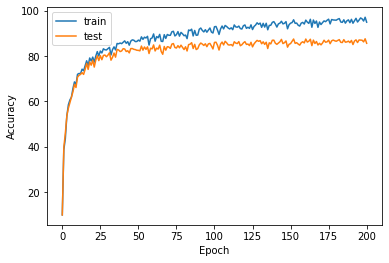

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

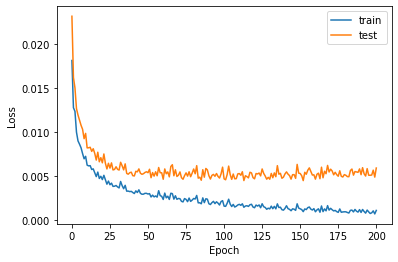

In [ ]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


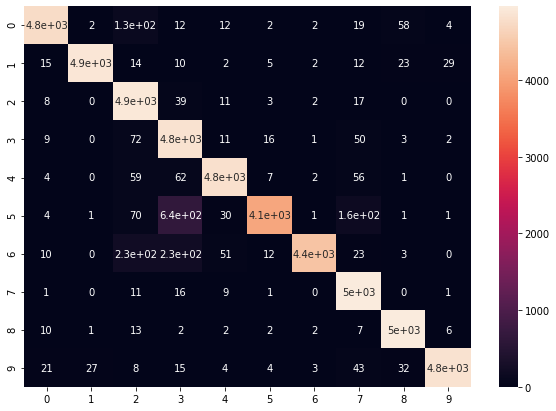

[ 각 클래스에 따른 정확도 ]
tensor([0.9526, 0.9776, 0.9840, 0.9672, 0.9618, 0.8174, 0.8890, 0.9922, 0.9910,
        0.9686])
[ 전체 평균 정확도 ]
tensor(0.9501)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = ResNet20()
net = net.to(device)

file_name = "./checkpoint/ResNet20_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


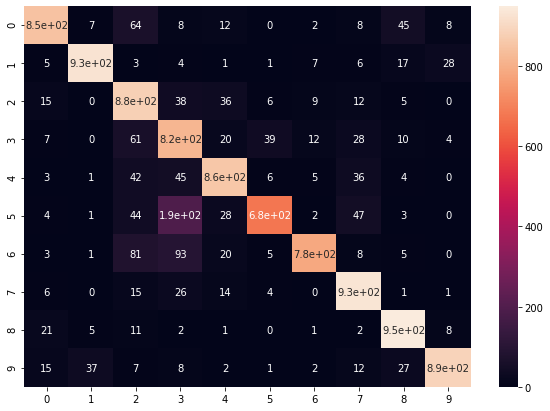

[ 각 클래스에 따른 정확도 ]
tensor([0.8460, 0.9280, 0.8790, 0.8190, 0.8580, 0.6780, 0.7840, 0.9330, 0.9490,
        0.8890])
[ 전체 평균 정확도 ]
tensor(0.8563)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = ResNet20()
net = net.to(device)

file_name = "./checkpoint/ResNet20_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [ ]:
from google.colab import files

In [ ]:
files.download('./checkpoint/ResNet20_CIFAR10.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>